# Практика 2: Калибровка и эпиполярная геометрия

Структура:
1) Импорт и пререквизиты
2) Поиск углов шахматки и сбор данных
3) Превью найденных углов
4) Калибровка (RMS, K, dist)
5) Интерпретация чисел и репроекционные ошибки
6) Галерея до/после undistort
7) Сохранение K/dist в JSON
8) Соответствия, F с RANSAC
9) Эпиполярные линии и их интерпретация
10) Бонус: E и recoverPose


## 1) Импорт и пререквизиты
Загружаем зависимости и задаём пути к данным. `pattern_size` — число внутренних углов (столбцы×строки) у шахматки.


In [3]:
import sys, subprocess, pkgutil, glob, os

def ensure(package):
    if pkgutil.find_loader(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for p in ["opencv-python", "numpy", "matplotlib"]:
    ensure(p)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV:", cv.__version__)

chess_dir = "./data/"      # изображения шахматки (jpg)
scene_dir = "./data/scene/" # два кадра сцены: img1.jpg/img2.jpg (или .jpeg)
pattern_size = (7, 6)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)


OpenCV: 4.9.0


## 2) Поиск углов шахматки и сбор данных
Извлекаем углы на каждой картинке, формируем `objpoints` (3D точки плоскости) и `imgpoints` (2D координаты углов).


In [4]:
objp = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

objpoints, imgpoints = [], []
img_shape = None
all_files = sorted(glob.glob(os.path.join(chess_dir, '*.jpg')))
for fname in all_files:
    img = cv.imread(fname)
    if img is None:
        continue
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if img_shape is None:
        img_shape = gray.shape[::-1]
    ret, corners = cv.findChessboardCorners(gray, pattern_size)
    if ret:
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        objpoints.append(objp)
        imgpoints.append(corners2)
print(f"Найдено кадров с углами: {len(imgpoints)} из {len(all_files)}")


Найдено кадров с углами: 14 из 14


## 3) Превью углов
Проверяем на нескольких кадрах корректность детекции (`drawChessboardCorners`).


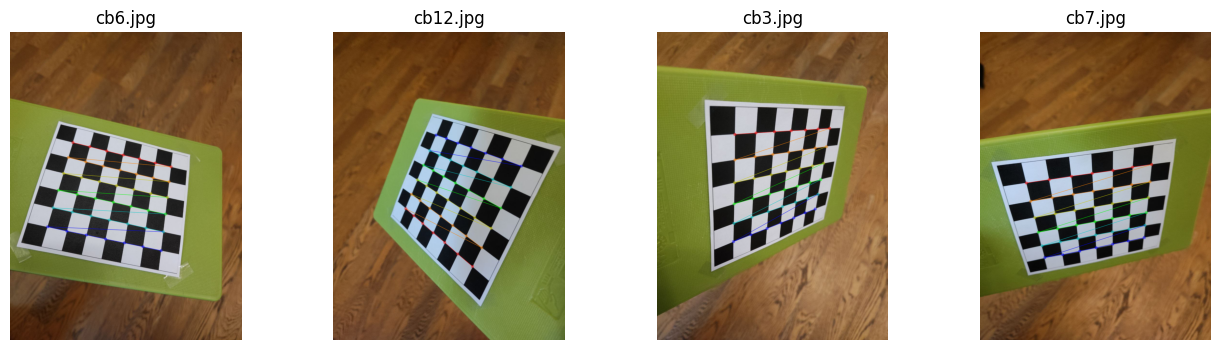

In [5]:
import random
found_idx = []
for i, fname in enumerate(all_files):
    img = cv.imread(fname)
    if img is None:
        continue
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, pattern_size)
    if ret:
        found_idx.append(i)

sample_idx = random.sample(found_idx, min(4, len(found_idx))) if found_idx else []
cols = len(sample_idx) if sample_idx else 1
plt.figure(figsize=(4*cols, 4))
for j, idx in enumerate(sample_idx):
    fname = all_files[idx]
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, pattern_size)
    if ret:
        cv.drawChessboardCorners(img, pattern_size, corners, ret)
    plt.subplot(1, cols, j+1)
    plt.title(os.path.basename(fname))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()


## 4) Калибровка (RMS, K, dist)
Оцениваем параметры камеры. RMS — средняя ошибка проекции по всем кадрам (в пикселях).


In [6]:
assert len(objpoints) >= 10, "Слишком мало кадров шахматки (нужно >=10)"
ret, K, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
print("RMS:", ret)
print("K:\n", K)
print("dist:", dist.ravel())


RMS: 0.575974482587258
K:
 [[912.40695372   0.         470.34069421]
 [  0.         910.52613104 645.39615658]
 [  0.           0.           1.        ]]
dist: [ 2.43932292e-01 -1.91434403e+00  2.00864457e-03 -1.40333157e-03
  3.65288889e+00]


## 5) Интерпретация метрик
Считаем репроекционные ошибки по кадрам и смотрим распределение (средняя/медиана/мин/макс).


In [7]:
per_frame_err = []
for i, (objp_i, imgp_i, rvec, tvec) in enumerate(zip(objpoints, imgpoints, rvecs, tvecs)):
    proj, _ = cv.projectPoints(objp_i, rvec, tvec, K, dist)
    err = cv.norm(imgp_i, proj, cv.NORM_L2) / len(proj)
    per_frame_err.append(float(err))
print("RMS:", float(ret))
print("Средняя:", float(np.mean(per_frame_err)), "Медианная:", float(np.median(per_frame_err)))
print("Мин/макс:", float(np.min(per_frame_err)), float(np.max(per_frame_err)))


RMS: 0.575974482587258
Средняя: 0.08705402268421794 Медианная: 0.08549837150806362
Мин/макс: 0.05801454843921435 0.13354161716750482


## 6) Галерея до/после undistort
Сравниваем несколько кадров до/после коррекции искажения.


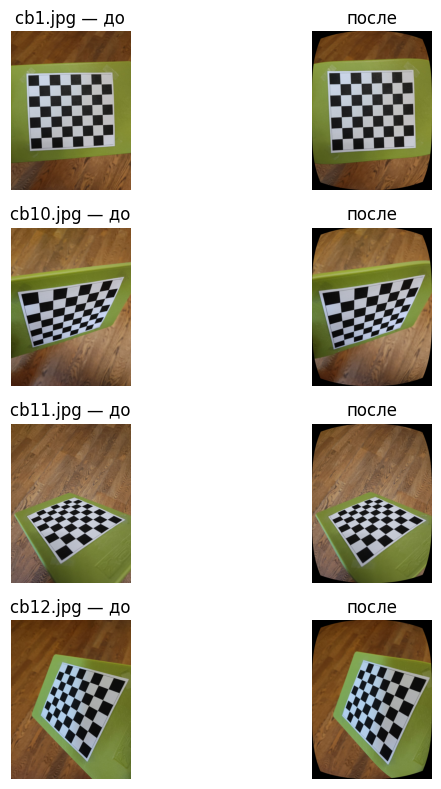

In [8]:
sample = cv.imread(all_files[0])
h, w = sample.shape[:2]
newK, roi = cv.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))
N = min(4, len(all_files))
sel = all_files[:N]
plt.figure(figsize=(8, 2*N))
for i, fname in enumerate(sel):
    img = cv.imread(fname)
    und_i = cv.undistort(img, K, dist, None, newK)
    plt.subplot(N, 2, 2*i+1); plt.title(f'{os.path.basename(fname)} — до'); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(N, 2, 2*i+2); plt.title('после'); plt.imshow(cv.cvtColor(und_i, cv.COLOR_BGR2RGB)); plt.axis('off')
plt.tight_layout(); plt.show()


## 7) Сохранение параметров K/dist
Сохраняем результат калибровки для дальнейших практик.


In [9]:
import json
os.makedirs("./outputs", exist_ok=True)
with open("./outputs/calib_params.json", "w") as f:
    json.dump({"K": K.tolist(), "dist": dist.ravel().tolist(), "RMS": float(ret)}, f, indent=2)
print("Сохранено: ./outputs/calib_params.json")


Сохранено: ./outputs/calib_params.json


## 8) Соответствия, F и RANSAC
Берём два кадра одной сцены, находим соответствия (ORB+BFMatcher), оцениваем F с RANSAC и смотрим долю инлиеров.


In [11]:
img1 = cv.imread(os.path.join(scene_dir, 'img1.jpg'))
img2 = cv.imread(os.path.join(scene_dir, 'img2.jpg'))
assert img1 is not None and img2 is not None, "Положите img1.jpg и img2.jpg в data/scene/"

orb = cv.ORB_create(2000)
kp1, des1 = orb.detectAndCompute(cv.cvtColor(img1, cv.COLOR_BGR2GRAY), None)
kp2, des2 = orb.detectAndCompute(cv.cvtColor(img2, cv.COLOR_BGR2GRAY), None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda m: m.distance)
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC, 1.0, 0.99)
print("Inliers:", int(mask.sum()), "/", len(mask))


Inliers: 340 / 840


## 9) Эпиполярные линии и интерпретация
Строим эпилинии только для инлиеров. Точки должны лежать на соответствующих линиях (с учётом дискретизации/шумов).


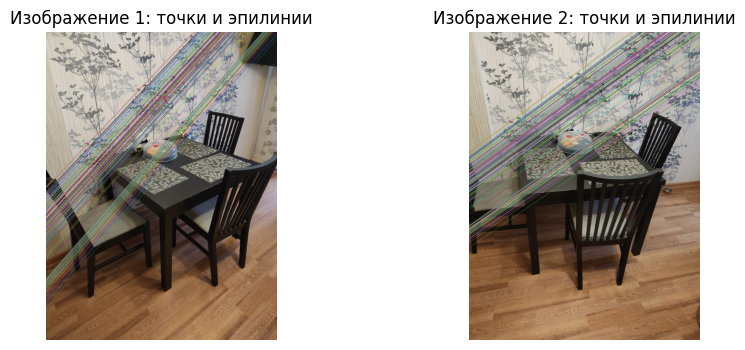

In [12]:
inliers_mask = mask.ravel()==1
inliers1 = pts1[inliers_mask]
inliers2 = pts2[inliers_mask]

lines1 = cv.computeCorrespondEpilines(inliers2.reshape(-1,1,2), 2, F).reshape(-1,3)
lines2 = cv.computeCorrespondEpilines(inliers1.reshape(-1,1,2), 1, F).reshape(-1,3)

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
img1_vis, img2_vis = img1.copy(), img2.copy()

for (r, pt) in zip(lines1, inliers1.reshape(-1,2)):
    color = tuple(np.random.randint(0,255,3).tolist())
    x0, y0 = 0, int(-r[2]/r[1]); x1, y1 = w1, int((-r[2]-r[0]*w1)/r[1])
    cv.line(img1_vis, (x0,y0), (x1,y1), color, 1)
    cv.circle(img1_vis, tuple(np.int32(pt)), 3, color, -1)

for (r, pt) in zip(lines2, inliers2.reshape(-1,2)):
    color = tuple(np.random.randint(0,255,3).tolist())
    x0, y0 = 0, int(-r[2]/r[1]); x1, y1 = w2, int((-r[2]-r[0]*w2)/r[1])
    cv.line(img2_vis, (x0,y0), (x1,y1), color, 1)
    cv.circle(img2_vis, tuple(np.int32(pt)), 3, color, -1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title('Изображение 1: точки и эпилинии'); plt.imshow(cv.cvtColor(img1_vis, cv.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,2,2); plt.title('Изображение 2: точки и эпилинии'); plt.imshow(cv.cvtColor(img2_vis, cv.COLOR_BGR2RGB)); plt.axis('off')
plt.show()


## 10) Бонус: E и recoverPose
Если известна K, можно получить эссенциальную матрицу E и восстановить относительную позу (с точностью до масштаба).


In [13]:
if 'K' in globals() and K is not None:
    E = K.T @ F @ K
    valid, R, t, mask_pose = cv.recoverPose(E, inliers1, inliers2, K)
    print("recoverPose valid:", valid, "inliers:", int(mask_pose.sum()))


recoverPose valid: 236 inliers: 60180
